<h1> Models </h1>

This python notebook describes the methods used for fitting gRNA:dCas9-mxi1 repression cascades to experimental data to by used in the Klavin's Lab *Gander et. al. 2015* publication.

Author: Justin Vrana

Date: 9-9-15

<h2> Model Equations </h2>


|                    |         $\frac{dr_0}{dt}$         | $\frac{dr_1}{dt}$                 | $\frac{dr_2}{dt}$                 | $\frac{dr_3}{dt}$                 | $\frac{dr_4}{dt}$ |
|--------------------|:---------------------------------:|-----------------------------------|-----------------------------------|-----------------------------------|-------------------|
| **Layer 1 (6059)** | $\frac{a_0}{1+k_0 r_1^n} - β r_0$ | $u_0 - β r_1$                     |                                   |                                   |                   |
| **Layer 2 (6325)** | $\frac{a_0}{1+k_0 r_1^n} - β r_0$ | $\frac{a_1}{1+k_1 r_2^n} - β r_1$ | $u_1 - β r_2$                     |                                   |                   |
| **Layer 3 (6326)** | $\frac{a_0}{1+k_0 r_1^n} - β r_0$ | $\frac{a_1}{1+k_1 r_2^n} - β r_1$ | $\frac{a_2}{1+k_2 r_3^n} - β r_2$ | $u_2 - β r_3$                     |                   |
| **Layer 4 (6327)** | $\frac{a_0}{1+k_0 r_1^n} - β r_0$ | $\frac{a_1}{1+k_1 r_2^n} - β r_1$ | $\frac{a_2}{1+k_2 r_3^n} - β r_2$ | $\frac{a_3}{1+k_3 r_4^n} - β r_3$ | $u_3 - β r_4$     |


| Parameter | Meaning                                              |
|-----------|------------------------------------------------------|
| a         | promoter strength                                    |
| k         | repression binding strength and respression strength |
| b         | degradation/dilution of gRNA:dCas9-mxi1              |
| u         | maximum induction of pGALZ4:Zev4 promoter            |
| n         | hill-coefficient                                     |
| $r_0$     | output gRNA in cascade                                 |

<h4> Kinetic and Steady-State Model Functions </h4>

In these plots, the resulting values the first index represents the final output gRNA, while the last index represents the first input gRNA, as displayed in the plot above.

In [7]:
import numpy as np
from scipy import integrate
from scipy import optimize
import pylab as plt
import pandas as pd
%matplotlib inline
from IPython import display

def cascade_kinetics(t, r, a, k, b, u, n):
    layer_depth = len(r) - 1
    dR = [0] * len(r)
    dR[layer_depth] = u[layer_depth-1] - b * r[layer_depth]
    for l in range(layer_depth)[::-1]:
        dR[l] = a[l] / (1+k[l] * r[l+1] ** n) - b * r[l]
    return dR

def cascade_ss(layer_depth, a, k, b, u, n):
    assert len(a) == len(k) == len(u)
    assert len(a) >= layer_depth
    u = u[layer_depth-1]
    R = [0]*(layer_depth+1)
    R[layer_depth] = u/b
    for l in range(layer_depth)[::-1]:
        R[l] = a[l] / ((1+k[l] * R[l+1] ** n)*b)
    return R

def tfxn(inducer_at_max, inducer):
    AB = 542.8745566
    K = 0.269635359
    n = 1.238933919
    def fxn(u):
        return (AB*K*u**n)/(1+K*u**n)
    rel_induction = fxn(inducer)/fxn(inducer_at_max)
    return rel_induction

t_final = 75.
dt = 1.0
def integrateSystem(numlayers, a, k, b, u, n):
    ss = cascade_ss(numlayers, a, k, b, np.zeros(len(a)), n)
    r1 = integrate.ode(cascade_kinetics)
    r1.set_initial_value(ss).set_f_params(a, k, b, u, n)
    data1 = []
    while r1.successful() and r1.t < t_final:
        r1.integrate(r1.t+dt)
        data1.append( [r1.t] + list(r1.y) )
    return data1

<h4> Plotting Kinetics Model </h4>

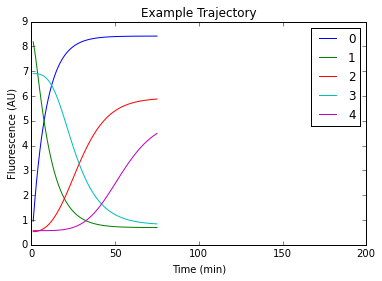

In [8]:
a = [1.0, 1.1, 1.2, 2.4]
k = [0.6, 0.65, 0.7, 0.8]
b = 0.12
u = [0.9, 0.85, 0.95, 1.01]
n = 1.445
params = [a, k, b, u, n]

def kineticsModel(a, k, b, u, n):
    assert len(a) == len(k) == len(u)
    num_layers = len(a)+1
    layers = {}
    time = []
    for l in range(num_layers):
        system = integrateSystem(l, a, k, b, u, n)
        unzipped = list(zip(*system))
        layers[l] = unzipped[1]
        time = unzipped[0]
    return pd.DataFrame(layers, index=time)

combined = kineticsModel(*params)

plt.figure()
combined.plot()
plt.xlim(0, 200)
plt.xlabel("Time (min)")
plt.ylabel("Fluorescence (AU)")
plt.title("Example Trajectory")
plt.legend(loc="best")
def getValue(t, df):
    i = np.abs(df.index - t).argmin()
    return df.iloc[i]

<h2> Steady State</h2>

<h3> Beta-estradiol transfer function </h3>
r_0 is the output of the GalZ:Zev4 activatable promoter, u is the beta-estradiol

$ r_0 = \frac{A K u^n}{B (1+K u^n)} $ 

$ \frac{dr_0}{dt} = \frac{A K u^n}{1+K u^n} - B r_0 $

$ \frac{A}{B} = 542.8745566$,
$ K = 0.269635359$,
$ n = 1.238933919$

**Insert Transfer Function Data Here! **
 
<h3> Steady State Equations </h3>
Derived from kinetic model above...

<h4> Plotting Steady State Model </h4>

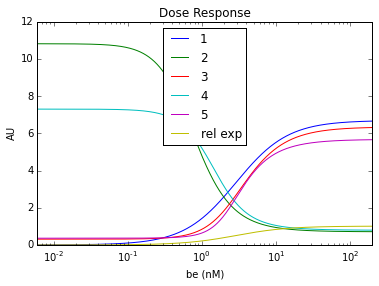

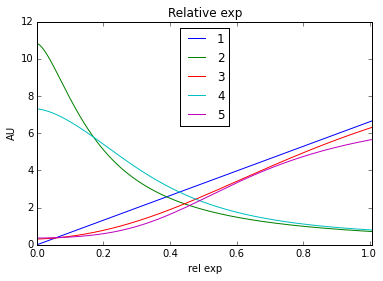

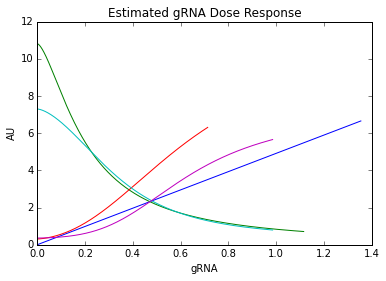

In [9]:
params = [1.85247556,  1.325424,    2.35268847,  1.6003237,   0.14792434,  0.68840386,
  0.41109531,  0.44726091,  0.43802356,  1.34453302,  1.10706773,  0.70852556,
  0.97811609,  1.56968898]
a = params[:4][::-1]
k = params[5:9][::-1]
b = params[4]
u = np.array(params[9:13])
n = params[13]
params = [a, k, b, u, n]

def ssModel(i_array, a, k, b, u, n):
    assert len(a) == len(k) == len(u)
    num_layers = len(a)+1
    dose = pd.DataFrame(index = i_array, columns = list(range(1,num_layers+1)) + ['rel exp'])
    for i in i_array:
        rel_exp = tfxn(100.0, i)
        rel_u = rel_exp * u
        dose.loc[i] = [cascade_ss(l, a, k, b, rel_u, n)[0] for l in range(num_layers)] + [rel_exp]
    return dose

dose = ssModel(0.006 * 2 ** np.linspace(0,15,1000), *params)
# Inducer Dose Response
ax = dose.plot(logx=True)
ax.set_xlabel("be (nM)")
ax.set_ylabel("AU")
ax.set_title("Dose Response")
ax

# Relative Expression Dose Response
ax = dose.set_index('rel exp').plot(logx=True)
ax.set_xlabel("rel exp")
ax.set_ylabel("AU")
ax.set_xscale("linear")
ax.set_title("Relative exp")
ax

# Estimated gRNA dose response 
plt.figure()
plt.title("Estimated gRNA Dose Response")
plt.xlabel("gRNA")
plt.ylabel("AU")
plt.plot(dose['rel exp'] * u[0], dose[1])
plt.plot(dose['rel exp'] * u[1], dose[2])
plt.plot(dose['rel exp'] * u[2], dose[3])
plt.plot(dose['rel exp'] * u[3], dose[4])
plt.plot(dose['rel exp'] * u[3], dose[5])
plt.show()

<h2>Import Data</h2>
<h3> Import Dose Response Data </h3>
18 cultures from 4 inducible cascades were measured at steady state (after 5 days) following induction with various amounts of beta-estradiol.

In [12]:
root_folder = "/Users/soslab/Google Drive/"
root_folder = "/Users/klavinslab/Google Drive/"
#root_folder = "/Users/Justin/Google Drive/"

strain,6059,6325,6326,6327
treatment,,,,
0.000000,18301.956899,1997.480763,13743.151208,2600.291009
0.006104,18044.821779,1970.962919,13790.219355,2499.949735
0.012207,17808.095515,2005.811138,13691.271563,2578.396007
0.024414,19383.397432,2036.892284,13655.662780,2647.932776
0.048828,18018.023608,2025.386391,13693.727803,2618.684317
0.097656,18380.900475,2123.193035,13658.250157,2969.426797
0.195312,19447.512475,2105.864566,13409.045555,2640.906220
0.390625,17758.588368,2237.879819,13106.537299,2755.025727
0.781250,13862.170586,2692.791667,11648.033159,3384.872367


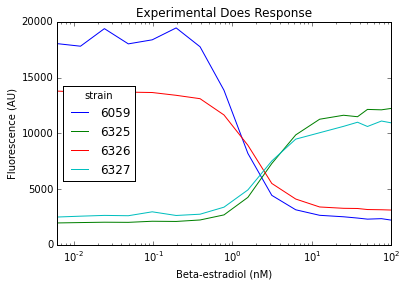

In [13]:
import pandas as pd

exp_dose = pd.read_csv(root_folder + "KlavinsLab/Projects/FSM/CSV/20150905_184902_CascadeDoseResponse_Final.csv")
AU = exp_dose['FL1.Amean']
treatment = exp_dose['treatment']
exp_dose = pd.pivot_table(exp_dose, index='treatment', columns=["strain"], values="FL1.Amean")
ax = exp_dose.plot(logx=True)
ax.set_xlabel("Beta-estradiol (nM)")
ax.set_ylabel("Fluorescence (AU)")
ax.set_title("Experimental Does Response")
ax
exp_dose

<h3>Import Kinetics Data</h3>

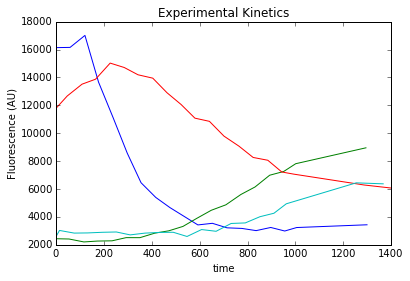

In [14]:
layers1 = pd.read_csv(root_folder + "KlavinsLab/projects/FSM/Analysis/KineticsData/Layer1.csv", header=None)
layers2 = pd.read_csv(root_folder + "KlavinsLab/projects/FSM/Analysis/KineticsData/Layer2.csv", header=None)
layers3 = pd.read_csv(root_folder + "KlavinsLab/projects/FSM/Analysis/KineticsData/Layer3.csv", header=None)
layers4 = pd.read_csv(root_folder + "KlavinsLab/projects/FSM/Analysis/KineticsData/Layer4.csv", header=None)


header = ['time', 'au']
layers1.columns = header
layers2.columns = header
layers3.columns = header
layers4.columns = header
layers1['layer'] = 1
layers2['layer'] = 2
layers3['layer'] = 3
layers4['layer'] = 4

#Triming kinetics data
ttrim = 1400
layers1 = layers1[layers1.time < ttrim]
layers2 = layers2[layers2.time < ttrim]
layers3 = layers3[layers3.time < ttrim]
layers4 = layers4[layers4.time < ttrim]

layers = pd.concat([layers1, layers2, layers3, layers4])
layers_table = pd.pivot_table(layers, values='au', columns=['layer'], index='time')
layers.sort(columns=['time', 'layer'])
layers['au'] = layers['au'] + 2000.
layers.stack()
layers
exp_kinetics = pd.pivot_table(layers, values='au', index=['layer', 'time'])
exp_kinetics
plt.figure()
plt.xlabel("Time (min)")
plt.ylabel("Fluorescence (AU)")
plt.title("Experimental Kinetics")
exp_kinetics[1].plot()
exp_kinetics[2].plot()
exp_kinetics[3].plot()
exp_kinetics[4].plot()
plt.show()
#exp_kinetics_trimed = exp_kinetics[exp_kinetics.time < 1200]
#exp_kinetics_trimed
trim_layer1 = exp_kinetics[1][exp_kinetics[1].index < 1400]
trim_layers = []
for i in range(1,5):
    trim_layer = exp_kinetics[i][exp_kinetics[i].index < 1400]
    trim_layers.append(trim_layer)
    trim_layer = pd.DataFrame(trim_layer)
    trim_layer['layer'] = i



<h2> Fitting </h2>

<h3> Scoring Function </h3>
$$χ^2_{red} = \frac{1}{v} \sum \frac{(O-E)^2}{σ^2} $$
$$ σ^2 \propto O^2 $$
$$ v = N - n - 1 $$
O is the observed data, E is the expected, and $σ^2$ is the covariance, which is estimated to be proporational to the square of the observed data. v is the degrees of freedom, N is the total number of experimental points, and n is the number of parameters.

I could either calculate chi-squared individually for each experiment and sum them (after normalization), or I could combine all points and calculate the chi-squared...

In [15]:
#imported data
#exp_kinetics
#exp_dose

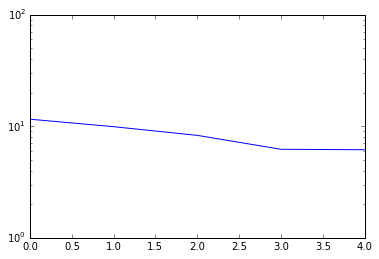

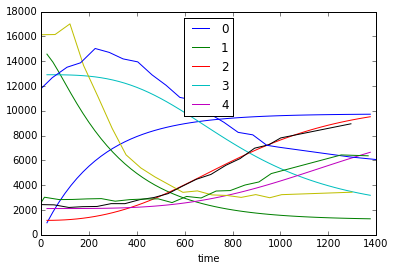

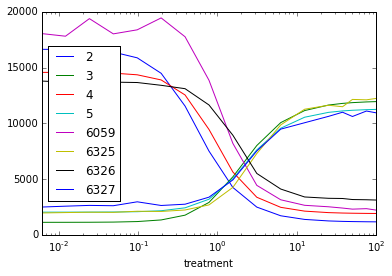

score         a                                       k            \
           0         0         1         2         3         0         1   
0  11.554184  0.854440  0.997112  1.036868  1.437777  0.443543  0.791818   
1  11.554184  0.854440  0.997112  1.036868  1.437777  0.443543  0.791818   
2   9.901532  1.018687  0.569544  0.900955  1.104512  1.355224  1.139773   
3   9.901532  1.018687  0.569544  0.900955  1.104512  1.355224  1.139773   
4   8.273861  0.981204  1.132908  0.830801  1.020242  0.491274  1.074833   
5   8.273861  0.981204  1.132908  0.830801  1.020242  0.491274  1.074833   
6   6.211423  1.241609  1.137891  1.350018  0.544637  0.523624  0.576962   
7   6.211423  1.241609  1.137891  1.350018  0.544637  0.523624  0.576962   
8   6.154552  0.968676  0.656996  1.160191  0.587319  1.010161  1.020485   
9   6.154552  0.968676  0.656996  1.160191  0.587319  1.010161  1.020485   

                              b                   u                      \
          2         3         0         1         0         1         2   
0  0.625922  1.324491  0.091231  0.106976  0.825089  0.825089  0.825089   
1  0.625922  1.324491  0.091231  0.106976  0.825089  0.825089  0.825089   
2  1.038964  1.346134  0.080530  0.105479  0.556578  0.556578  0.556578   
3  1.038964  1.346134  0.080530  0.105479  0.556578  0.556578  0.556578   
4  1.080540  0.640911  0.098264  0.100622  0.617370  0.617370  0.617370   
5  1.080540  0.640911  0.098264  0.100622  0.617370  0.617370  0.617370   
6  1.219669  0.492542  0.101121  0.096902  0.497152  0.497152  0.497152   
7  1.219669  0.492542  0.101121  0.096902  0.497152  0.497152  0.497152   
8  1.443361  0.535421  0.104526  0.093128  0.637325  0.637325  0.637325   
9  1.443361  0.535421  0.104526  0.093128  0.637325  0.637325  0.637325   

                    n  
          3         0  
0  0.825089  1.243899  
1  0.825089  1.243899  
2  0.556578  1.223037  
3  0.556578  1.223037  
4  0.617370  1.213264  
5  0.617370  1.213264  
6  0.497152  1.252070  
7  0.497152  1.252070  
8  0.637325  1.335357  
9  0.637325  1.335357

strain,6059,6325,6326,6327
treatment,,,,
0.000000,-8.475557,0.8948602,-2.303618,0.9407417
0.006104,-8.720883,0.8674149,-2.248625,0.8398393
0.012207,-8.932444,0.9002835,-2.330678,0.9170875
0.024414,-7.278719,0.9251676,-2.313563,0.98287
0.048828,-8.402545,0.8943049,-2.112439,0.9418582
0.097656,-7.319881,0.9319174,-1.656279,1.255669
0.195312,-4.292361,0.7290689,-0.5282816,0.810153
0.390625,-1.678573,0.3028291,2.29992,0.5471913
0.781250,0.7129956,-0.7828598,5.224252,0.004984659


strain,6059,6325,6326,6327
treatment,,,,
0.000000,11.55871,1.805027,10.70493,2.358587
0.006104,11.3033,1.778463,10.75245,2.258218
0.012207,11.07021,1.813214,10.65445,2.336607
0.024414,12.6568,1.843993,10.62178,2.405965
0.048828,11.32613,1.831549,10.66893,2.376162
0.097656,11.79338,1.92647,10.6611,2.725186
0.195312,13.15555,1.900403,10.493,2.391352
0.390625,12.18718,2.006841,10.40696,2.489058
0.781250,9.577511,2.392314,9.41174,3.068926


strain,6059,6325,6326,6327
treatment,,,,
0.000000,2.548495,1.163951,7.115845,1.234274
0.006104,2.31099,1.136552,7.167467,1.133151
0.012207,2.109189,1.169827,7.076634,1.210203
0.024414,3.780797,1.196531,7.063495,1.27586
0.048828,2.676259,1.172889,7.163104,1.235844
0.097656,3.71341,1.237271,7.291508,1.556884
0.195312,6.336144,1.129371,7.448589,1.147616
0.390625,7.474751,1.025345,7.997824,1.051229
0.781250,7.057858,0.9210926,7.822803,1.197089


strain,6059,6325,6326,6327
treatment,,,,
0.000000,2.432847,-1.110466,3.524414,-1.971157
0.006104,2.21748,-1.142003,3.587704,-2.078184
0.012207,2.040548,-1.11438,3.512006,-2.009347
0.024414,3.759687,-1.100875,3.532462,-1.963112
0.048828,2.733062,-1.1549,3.703319,-2.048293
0.097656,3.855554,-1.158598,3.969458,-1.828599
0.195312,6.453851,-1.410886,4.344475,-2.44733
0.390625,7.286622,-1.786383,5.115339,-2.901294
0.781250,6.426092,-2.281842,5.019862,-3.151667


strain,6059,6325,6326,6327
treatment,,,,
0.000000,-2.676907,0.3700165,-3.273726,-1.490482
0.006104,-2.91366,0.3417544,-3.221678,-1.592529
0.012207,-3.112484,0.3733497,-3.31134,-1.517265
0.024414,-1.429534,0.3951264,-3.320407,-1.45683
0.048828,-2.494069,0.3570915,-3.206822,-1.512026
0.097656,-1.325723,0.3798221,-3.02989,-1.234687
0.195312,1.677952,0.1538169,-2.699752,-1.767036
0.390625,3.6747,-0.2684393,-1.553482,-2.192716
0.781250,4.501142,-1.122755,-0.1416726,-2.822283


strain,6059,6325,6326,6327
treatment,,,,
0.000000,-7.016511,0.5504859,-5.171767,-0.3336019
0.006104,-7.249932,0.5230072,-5.121144,-0.4350194
0.012207,-7.441352,0.5560143,-5.213283,-0.3586353
0.024414,-5.735091,0.5817354,-5.229083,-0.2951046
0.048828,-6.728144,0.5546708,-5.133658,-0.3418056
0.097656,-5.352921,0.6076263,-5.00493,-0.04152655
0.195312,-1.827947,0.4630389,-4.797481,-0.5143922
0.390625,1.143113,0.2472348,-3.920959,-0.802181
0.781250,3.082377,-0.1653932,-2.849612,-1.203057


strain,6059,6325,6326,6327
treatment,,,,
0.000000,9.392027,1.565245,7.765745,2.143559
0.006104,9.138849,1.538623,7.814269,2.043208
0.012207,8.9116,1.573221,7.718813,2.121631
0.024414,10.51891,1.603451,7.69504,2.191089
0.048828,9.260054,1.589067,7.772983,2.161573
0.097656,9.961924,1.6772,7.869583,2.511407
0.195312,11.9779,1.627803,8.035799,2.179793
0.390625,12.24034,1.656535,8.835243,2.283097
0.781250,10.69409,1.801917,9.16683,2.873177


strain,6059,6325,6326,6327
treatment,,,,
0.000000,7.834995,1.77263,7.300086,2.343368
0.006104,7.579052,1.746075,7.348094,2.243018
0.012207,7.345468,1.780825,7.251622,2.321442
0.024414,8.932162,1.811548,7.224997,2.390895
0.048828,7.607776,1.798749,7.295472,2.361345
0.097656,8.114927,1.891901,7.37513,2.710994
0.195312,9.657611,1.858021,7.516695,2.378479
0.390625,9.283505,1.932313,8.35672,2.477426
0.781250,7.831825,2.194385,9.001275,3.043952


strain,6059,6325,6326,6327
treatment,,,,
0.000000,-4.622476,-3.373827,-6.674019,-8.656177
0.006104,-4.872195,-3.403569,-6.62592,-8.760436
0.012207,-5.095601,-3.374514,-6.723014,-8.689026
0.024414,-3.483176,-3.359603,-6.753447,-8.639108
0.048828,-4.74584,-3.416018,-6.700973,-8.722684
0.097656,-4.104016,-3.441474,-6.696667,-8.519838
0.195312,-2.314149,-3.787373,-6.838079,-9.233778
0.390625,-2.322008,-4.471475,-6.861162,-10.02088
0.781250,-3.099042,-5.744163,-7.665341,-11.04219


strain,6059,6325,6326,6327
treatment,,,,
0.000000,-3.347094,1.033332,3.696687,0.8054963
0.006104,-3.601324,1.006736,3.744433,0.7049139
0.012207,-3.831232,1.0414,3.647078,0.782794
0.024414,-2.233171,1.071867,3.616788,0.8504374
0.048828,-3.523106,1.058316,3.672535,0.8148754
0.097656,-2.914901,1.149365,3.695118,1.144681
0.195312,-1.091522,1.110106,3.630526,0.7474562
0.390625,-0.7477757,1.173711,3.868486,0.6411762
0.781250,-0.6274938,1.432406,3.705247,0.6161708


strain,6059,6325,6326,6327
treatment,,,,
0.000000,-2.222083,1.631971,-2.155339,2.201267
0.006104,-2.475585,1.605359,-2.107041,2.100916
0.012207,-2.702119,1.63994,-2.202535,2.179338
0.024414,-1.088178,1.670009,-2.225016,2.248779
0.048828,-2.308612,1.654662,-2.137221,2.219168
0.097656,-1.420018,1.737948,-1.985679,2.568529
0.195312,1.363161,1.6658,-1.54407,2.234662
0.390625,3.879523,1.589014,0.5211646,2.326505
0.781250,5.846842,1.254884,4.572102,2.845451


strain,6059,6325,6326,6327
treatment,,,,
0.000000,-0.355458,1.533673,0.8123146,1.371341
0.006104,-0.6023621,1.506822,0.8609502,1.270699
0.012207,-0.8181795,1.540989,0.7652106,1.348531
0.024414,0.8204361,1.569995,0.7393565,1.416198
0.048828,-0.3556278,1.552188,0.8069524,1.381273
0.097656,0.553806,1.630961,0.8599137,1.714865
0.195312,3.058314,1.556726,0.8685062,1.335047
0.390625,4.410181,1.522617,1.268104,1.298898
0.781250,4.826057,1.524162,1.42678,1.51214


strain,6059,6325,6326,6327
treatment,,,,
0.000000,-4.693876,0.8545632,-0.8866934,-1.131094
0.006104,-4.855056,0.8237248,-0.8234743,-1.241697
0.012207,-4.943947,0.8518456,-0.8973343,-1.179208
0.024414,-2.999734,0.8657543,-0.8692344,-1.150286
0.048828,-3.478066,0.8105645,-0.6712203,-1.282086
0.097656,-1.159025,0.7981747,-0.3162343,-1.185123
0.195312,3.508999,0.508581,0.3258579,-2.110329
0.390625,6.690983,0.002022835,1.775085,-3.233642
0.781250,7.237416,-0.8673142,2.909038,-4.575135


strain,6059,6325,6326,6327
treatment,,,,
0.000000,10.41431,0.9430459,8.81427,1.298672
0.006104,10.16706,0.9145268,8.867008,1.197911
0.012207,9.945726,0.9462502,8.77689,1.275702
0.024414,11.56013,0.9693467,8.763714,1.343562
0.048828,10.29272,0.9375375,8.857992,1.310037
0.097656,10.89294,0.9843231,8.958689,1.649945
0.195312,12.49123,0.8423725,9.013968,1.294429
0.390625,11.81237,0.6896513,9.283667,1.343938
0.781250,9.354748,0.5824099,8.611681,1.83334


strain,6059,6325,6326,6327
treatment,,,,
0.000000,-0.3937903,1.480031,-3.897314,1.759792
0.006104,-0.6466757,1.453274,-3.849619,1.659289
0.012207,-0.871744,1.487467,-3.946843,1.737292
0.024414,0.7470128,1.516097,-3.976,1.805169
0.048828,-0.4583054,1.495432,-3.913744,1.769693
0.097656,0.4720687,1.55903,-3.857762,2.096835
0.195312,3.326953,1.41305,-3.74902,1.674685
0.390625,5.760451,1.051961,-2.551784,1.35916
0.781250,7.16948,-0.2886429,1.248919,-0.4093662


strain,6059,6325,6326,6327
treatment,,,,
0.000000,11.09755,1.51703,7.359684,1.073098
0.006104,10.84283,1.490259,7.406998,0.9720609
0.012207,10.61177,1.524513,7.308627,1.048878
0.024414,12.20588,1.553614,7.274943,1.112974
0.048828,10.90235,1.535514,7.319412,1.065603
0.097656,11.46168,1.611488,7.305126,1.356236
0.195312,13.09474,1.522685,7.125206,0.8305729
0.390625,12.68701,1.427505,7.043017,0.3348632
0.781250,10.61953,1.235302,6.221262,-0.4212485


strain,6059,6325,6326,6327
treatment,,,,
0.000000,7.113727,1.443427,9.197454,1.548454
0.006104,6.862342,1.416522,9.245597,1.447531
0.012207,6.637098,1.450595,9.148797,1.524813
0.024414,8.246644,1.479355,9.119613,1.59086
0.048828,6.982232,1.460915,9.176757,1.551186
0.097656,7.633515,1.538134,9.196958,1.870958
0.195312,9.458368,1.460529,9.102946,1.451898
0.390625,9.408583,1.421839,9.185923,1.315383
0.781250,7.965908,1.43402,8.467662,1.372877


strain,6059,6325,6326,6327
treatment,,,,
0.000000,-7.892801,-0.2512219,-1.260785,-0.2928434
0.006104,-8.133537,-0.2793891,-1.208994,-0.3935718
0.012207,-8.34093,-0.2474962,-1.299487,-0.3158193
0.024414,-6.684223,-0.2246513,-1.311574,-0.2482168
0.048828,-7.826108,-0.2590339,-1.208505,-0.2828441
0.097656,-6.866652,-0.2242635,-1.067351,0.05302899
0.195312,-4.315428,-0.4120361,-0.8565482,-0.316053
0.390625,-2.856008,-0.7207175,-0.07811254,-0.3092536
0.781250,-1.81653,-1.292273,0.4932698,0.05657228


strain,6059,6325,6326,6327
treatment,,,,
0.000000,11.46538,1.60182,10.34091,1.821146
0.006104,11.21943,1.574721,10.39025,1.720495
0.012207,10.9986,1.608741,10.29453,1.7985
0.024414,12.61211,1.637814,10.26672,1.866968
0.048828,11.33729,1.621461,10.32346,1.835142
0.097656,11.90778,1.707665,10.33189,2.179717
0.195312,13.41646,1.663093,10.18151,1.836737
0.390625,12.53735,1.73388,10.08139,1.918478
0.781250,9.78628,2.063615,8.967798,2.482619


strain,6059,6325,6326,6327
treatment,,,,
0.000000,8.63508,1.696491,12.27417,2.247532
0.006104,8.398616,1.669754,12.32232,2.147115
0.012207,8.19817,1.704215,12.22529,2.225427
0.024414,9.872234,1.734228,12.19493,2.294594
0.048828,8.768437,1.719779,12.24722,2.264326
0.097656,9.777364,1.809537,12.24908,2.612268
0.195312,12.20117,1.770531,12.09004,2.276123
0.390625,12.60481,1.846196,11.96846,2.370028
0.781250,10.79505,2.166066,10.7676,2.950487


strain,6059,6325,6326,6327
treatment,,,,
0.000000,7.892214,1.610243,3.947518,2.047092
0.006104,7.636783,1.583615,3.994736,1.946695
0.012207,7.404785,1.618157,3.896203,2.024987
0.024414,8.997866,1.648085,3.862162,2.093944
0.048828,7.698698,1.63224,3.906129,2.062507
0.097656,8.300586,1.713786,3.892832,2.404957
0.195312,10.15105,1.635715,3.727391,2.044217
0.390625,10.4365,1.540944,3.749274,2.02068
0.781250,9.459722,1.190268,3.536941,1.942146


strain,6059,6325,6326,6327
treatment,,,,
0.000000,10.06811,1.841815,10.54646,2.414667
0.006104,9.818264,1.815083,10.59696,2.314284
0.012207,9.597805,1.849453,10.50569,2.392637
0.024414,11.22527,1.878984,10.49473,2.461871
0.048828,10.02353,1.862462,10.61038,2.431637
0.097656,10.86778,1.944001,10.80513,2.779141
0.195312,13.12642,1.873564,11.13144,2.43958
0.390625,13.47341,1.8314,11.76817,2.513043
0.781250,11.57744,1.753592,11.05185,2.985747


strain,6059,6325,6326,6327
treatment,,,,
0.000000,-4.010855,0.09332447,-1.036995,-0.1393915
0.006104,-4.222487,0.06471978,-0.9709368,-0.2408109
0.012207,-4.383803,0.096091,-1.038333,-0.1641614
0.024414,-2.610234,0.1179183,-0.9905046,-0.09940952
0.048828,-3.466327,0.08187079,-0.734884,-0.1413679
0.097656,-1.868781,0.1151374,-0.2232999,0.1758123
0.195312,1.818721,-0.06855519,0.7837525,-0.2401099
0.390625,4.420381,-0.3455251,2.823871,-0.345881
0.781250,5.282993,-0.7926717,4.346633,-0.2223906


strain,6059,6325,6326,6327
treatment,,,,
0.000000,1.081007,1.564392,-3.102934,2.014213
0.006104,0.8263462,1.537734,-3.055745,1.913823
0.012207,0.5965683,1.572191,-3.154353,1.992131
0.024414,2.198243,1.601782,-3.188669,2.06114
0.048828,0.9320396,1.584616,-3.145685,2.029885
0.097656,1.657094,1.660978,-3.162391,2.372949
0.195312,3.931666,1.56223,-3.338419,2.014209
0.390625,5.372023,1.380796,-3.332982,1.995696
0.781250,6.285982,0.659555,-3.349224,1.873897


strain,6059,6325,6326,6327
treatment,,,,
0.000000,8.034436,1.141733,5.784301,-0.712979
0.006104,7.786206,1.114607,5.832242,-0.815645
0.012207,7.56732,1.148235,5.735048,-0.7418642
0.024414,9.195829,1.175649,5.704702,-0.6863107
0.048828,7.986443,1.153163,5.758505,-0.7571519
0.097656,8.78545,1.218333,5.769623,-0.5275762
0.195312,10.93057,1.105649,5.655028,-1.188987
0.390625,11.27488,0.9708065,5.718035,-1.850262
0.781250,9.827507,0.7597526,5.108389,-2.438068


strain,6059,6325,6326,6327
treatment,,,,
0.000000,2.116811,1.785406,-0.4712623,1.511449
0.006104,1.863283,1.758838,-0.4238753,1.410518
0.012207,1.636436,1.793548,-0.5219491,1.487345
0.024414,3.248515,1.824111,-0.5542936,1.550821
0.048828,2.018458,1.810675,-0.5040718,1.49883
0.097656,2.86095,1.901323,-0.4945255,1.763015
0.195312,5.441924,1.857546,-0.5784534,1.087351
0.390625,7.270047,1.891714,-0.2832076,-0.3254794
0.781250,7.961488,1.988091,0.2620339,-4.597745


strain,6059,6325,6326,6327
treatment,,,,
0.000000,9.007215,1.825019,7.386535,2.416936
0.006104,8.751192,1.798483,7.434424,2.316591
0.012207,8.517428,1.833284,7.337665,2.395027
0.024414,10.10355,1.86419,7.310065,2.464526
0.048828,8.777424,1.852045,7.37729,2.43514
0.097656,9.279333,1.947538,7.446678,2.785379
0.195312,10.80578,1.921951,7.561229,2.454974
0.390625,10.37452,2.025294,8.369233,2.561548
0.781250,8.743252,2.385909,9.063769,3.156283


strain,6059,6325,6326,6327
treatment,,,,
0.000000,0.8028282,1.532247,2.547614,1.863411
0.006104,0.5489929,1.505668,2.595887,1.763007
0.012207,0.3199533,1.540375,2.499748,1.841304
0.024414,1.920764,1.570984,2.473472,1.910348
0.048828,0.6393614,1.557914,2.542408,1.879461
0.097656,1.272413,1.650576,2.607813,2.224792
0.195312,3.154339,1.616596,2.677992,1.878518
0.390625,3.548185,1.696562,3.303569,1.9349
0.781250,3.385514,2.000346,3.985738,2.379912


strain,6059,6325,6326,6327
treatment,,,,
0.000000,4.755957,1.335961,6.756904,0.4530824
0.006104,4.528426,1.307949,6.809558,0.3488512
0.012207,4.340286,1.340331,6.719814,0.4208841
0.024414,6.042503,1.364885,6.708458,0.4734962
0.048828,5.000718,1.336155,6.809778,0.3999405
0.097656,6.140836,1.388835,6.935079,0.6370396
0.195312,8.837062,1.255321,7.069516,0.03203134
0.390625,9.775134,1.101083,7.559296,-0.4431386
0.781250,8.748913,0.923277,7.333537,-0.7586862


strain,6059,6325,6326,6327
treatment,,,,
0.000000,-0.6060359,-1.164504,0.2605517,-0.9306402
0.006104,-0.8473618,-1.192792,0.3162098,-1.031657
0.012207,-1.055425,-1.16116,0.2328493,-0.9544398
0.024414,0.6000292,-1.139121,0.2409208,-0.8883646
0.048828,-0.5442529,-1.175947,0.4001674,-0.9273565
0.097656,0.4070199,-1.148347,0.6920142,-0.604016
0.195312,2.905566,-1.355775,1.266254,-1.009468
0.390625,4.073219,-1.710005,2.693803,-1.108712
0.781250,4.181884,-2.346435,3.731559,-1.03014


strain,6059,6325,6326,6327
treatment,,,,
0.000000,-2.306965,-0.734203,-2.051809,-4.149392
0.006104,-2.552683,-0.762751,-2.003668,-4.251852
0.012207,-2.770647,-0.7312431,-2.100852,-4.176891
0.024414,-1.145954,-0.7089812,-2.131803,-4.116551
0.048828,-2.382422,-0.7436826,-2.081484,-4.169951
0.097656,-1.69025,-0.7063225,-2.085016,-3.881901
0.195312,0.1750203,-0.8777603,-2.25267,-4.368659
0.390625,0.208797,-1.119092,-2.356859,-4.628441
0.781250,-0.7347352,-1.471839,-3.381477,-4.762839


strain,6059,6325,6326,6327
treatment,,,,
0.000000,10.89745,1.737397,8.525587,2.326803
0.006104,10.64051,1.71087,8.572757,2.226461
0.012207,10.40441,1.745691,8.474125,2.304906
0.024414,11.98227,1.776661,8.439811,2.374433
0.048828,10.62731,1.764699,8.483165,2.345149
0.097656,11.03204,1.860659,8.469079,2.695743
0.195312,12.2597,1.83598,8.30435,2.366628
0.390625,11.11808,1.939758,8.31561,2.478371
0.781250,8.578119,2.29312,7.824356,3.098469


strain,6059,6325,6326,6327
treatment,,,,
0.000000,1.969268,1.522267,-2.070737,1.65035
0.006104,1.714236,1.495649,-2.023607,1.549908
0.012207,1.48405,1.530185,-2.122362,1.628041
0.024414,3.08615,1.559984,-2.157177,1.696289
0.048828,1.829421,1.543225,-2.115862,1.661748
0.097656,2.617775,1.619561,-2.13806,1.99066
0.195312,5.170055,1.514165,-2.332823,1.569234
0.390625,7.219198,1.276368,-2.403734,1.233976
0.781250,8.265655,0.2054731,-2.78666,-0.8335993


strain,6059,6325,6326,6327
treatment,,,,
0.000000,2.646946,1.582417,10.58303,2.124161
0.006104,2.40375,1.555662,10.63249,2.023749
0.012207,2.191054,1.5901,10.53767,2.102074
0.024414,3.83143,1.620064,10.51323,2.171279
0.048828,2.640003,1.605524,10.58123,2.14113
0.097656,3.452654,1.695148,10.6236,2.489432
0.195312,5.591538,1.6561,10.56248,2.154363
0.390625,6.040879,1.732524,10.6447,2.251297
0.781250,5.240551,2.056223,9.760506,2.838753


strain,6059,6325,6326,6327
treatment,,,,
0.000000,3.420733,1.236296,2.988856,1.464616
0.006104,3.166429,1.209649,3.037394,1.364127
0.012207,2.935855,1.244217,2.94164,1.44225
0.024414,4.53062,1.27441,2.91615,1.510765
0.048828,3.226374,1.260098,2.986125,1.47828
0.097656,3.777441,1.349108,3.050143,1.818819
0.195312,5.393103,1.30467,3.102164,1.458308
0.390625,5.101955,1.356232,3.641472,1.472953
0.781250,3.860789,1.591381,4.071491,1.801975


strain,6059,6325,6326,6327
treatment,,,,
0.000000,2.31281,1.800281,3.613198,2.080332
0.006104,2.061261,1.773687,3.661463,1.979766
0.012207,1.839434,1.808333,3.565712,2.057612
0.024414,3.469086,1.838674,3.541811,2.124942
0.048828,2.298962,1.824456,3.622535,2.087572
0.097656,3.32964,1.912358,3.740418,2.408025
0.195312,6.364248,1.858775,4.021739,1.960802
0.390625,8.681121,1.85611,5.339478,1.552507
0.781250,9.16354,1.812896,7.168809,0.03029865


strain,6059,6325,6326,6327
treatment,,,,
0.000000,3.583975,1.334547,3.081328,1.88224
0.006104,3.330617,1.30783,3.129651,1.781873
0.012207,3.102982,1.342197,3.033725,1.860257
0.024414,4.709133,1.37164,3.008398,1.929583
0.048828,3.447384,1.354577,3.081284,1.899617
0.097656,4.148008,1.433633,3.162438,2.247912
0.195312,6.223931,1.353793,3.292429,1.910969
0.390625,6.946049,1.282467,4.117364,1.994955
0.781250,6.744366,1.120081,5.183641,2.509195


strain,6059,6325,6326,6327
treatment,,,,
0.000000,2.85288,1.775098,8.489702,2.368058
0.006104,2.603509,1.748486,8.539962,2.267713
0.012207,2.385864,1.7831,8.448861,2.34615
0.024414,4.026737,1.813374,8.440243,2.415655
0.048828,2.882883,1.799084,8.569768,2.386296
0.097656,3.955757,1.887316,8.83007,2.736655
0.195312,6.977806,1.837187,9.409662,2.406802
0.390625,9.054166,1.85714,10.67907,2.516118
0.781250,9.211595,1.940009,10.62701,3.127411


strain,6059,6325,6326,6327
treatment,,,,
0.000000,-0.6452605,1.668085,0.6027549,2.166771
0.006104,-0.9001631,1.641499,0.6517074,2.066414
0.012207,-1.130083,1.676139,0.5585068,2.144815
0.024414,0.472683,1.706376,0.5461264,2.214166
0.048828,-0.7829269,1.691464,0.6776393,2.18417
0.097656,0.005238223,1.775566,1.013362,2.531896
0.195312,2.561423,1.702953,2.170978,2.191102
0.390625,4.775114,1.606633,6.019023,2.25232
0.781250,6.522119,1.10476,9.443038,2.61207


strain,6059,6325,6326,6327
treatment,,,,
0.000000,-9.657583,0.7934449,4.299112,0.4381589
0.006104,-9.706378,0.7626221,4.365563,0.3347109
0.012207,-9.661368,0.791547,4.293147,0.4088849
0.024414,-7.439939,0.8085832,4.319815,0.4683037
0.048828,-7.391492,0.7639065,4.501535,0.415225
0.097656,-4.229377,0.7840926,4.784488,0.7105651
0.195312,1.424732,0.5889847,5.182855,0.2570349
0.390625,5.342933,0.333056,5.993508,0.1071909
0.781250,6.286142,0.02404851,5.990218,0.2504078


strain,6059,6325,6326,6327
treatment,,,,
0.000000,8.812207,1.418444,5.959005,1.516297
0.006104,8.558164,1.391442,6.00754,1.415509
0.012207,8.326878,1.425437,5.911174,1.493167
0.024414,9.917145,1.454166,5.88268,1.560531
0.048828,8.592644,1.436198,5.94027,1.525303
0.097656,9.065174,1.516374,5.957848,1.859683
0.195312,10.41319,1.451777,5.849349,1.486918
0.390625,9.375093,1.462108,5.898024,1.484858
0.781250,6.693587,1.632162,5.195448,1.832416


strain,6059,6325,6326,6327
treatment,,,,
0.000000,-2.447165,0.2387955,-2.744153,-1.42476
0.006104,-2.696038,0.2109505,-2.693345,-1.528793
0.012207,-2.915914,0.2430886,-2.784657,-1.457886
0.024414,-1.289609,0.265938,-2.797088,-1.411263
0.048828,-2.502159,0.2295076,-2.688972,-1.509995
0.097656,-1.69389,0.2523867,-2.515091,-1.368847
0.195312,0.578654,0.01360741,-2.157364,-2.317957
0.390625,1.622938,-0.4808574,-0.854562,-3.885066
0.781250,2.101665,-1.594732,0.9348325,-6.507931


strain,6059,6325,6326,6327
treatment,,,,
0.000000,8.25481,0.6201664,3.978317,1.178732
0.006104,7.998217,0.5935072,4.025506,1.078375
0.012207,7.763215,0.6279062,3.926943,1.156772
0.024414,9.345699,0.6571143,3.892938,1.226102
0.048828,8.010042,0.6378261,3.937721,1.195992
0.097656,8.493295,0.7035653,3.930788,1.54308
0.195312,10.01599,0.5563765,3.811171,1.198022
0.390625,9.739948,0.1845438,4.199893,1.218707
0.781250,8.560712,-1.008763,5.774663,1.079097


strain,6059,6325,6326,6327
treatment,,,,
0.000000,8.500955,1.291476,5.588719,1.258989
0.006104,8.251351,1.264583,5.637136,1.158023
0.012207,8.030599,1.298634,5.541056,1.235142
0.024414,9.655412,1.327227,5.514396,1.300532
0.048828,8.440836,1.307977,5.580298,1.258337
0.097656,9.240603,1.381848,5.630735,1.568671
0.195312,11.41535,1.291667,5.641151,1.113859
0.390625,11.81273,1.210026,6.070223,0.8367205
0.781250,10.33082,1.098655,6.23067,0.3928526


strain,6059,6325,6326,6327
treatment,,,,
0.000000,-3.977182,1.768922,-0.2704854,2.352468
0.006104,-4.232854,1.742391,-0.2230082,2.252125
0.012207,-4.465072,1.777199,-0.3206947,2.330567
0.024414,-2.871417,1.808114,-0.3511642,2.400084
0.048828,-4.162615,1.795937,-0.2922497,2.370755
0.097656,-3.506503,1.891038,-0.244059,2.721171
0.195312,-1.358659,1.86296,-0.1666634,2.391338
0.390625,0.1947379,1.953231,0.7124846,2.500072
0.781250,2.323909,2.251403,2.620516,3.105884


strain,6059,6325,6326,6327
treatment,,,,
0.000000,11.13809,1.593285,6.916031,1.619411
0.006104,10.88109,1.566748,6.963112,1.519036
0.012207,10.64477,1.60154,6.864202,1.597384
0.024414,12.22163,1.632404,6.828739,1.666542
0.048828,10.86228,1.620059,6.867366,1.635828
0.097656,11.2481,1.714652,6.834043,1.980946
0.195312,12.39933,1.685234,6.592969,1.631111
0.390625,10.99629,1.773423,6.320212,1.666049
0.781250,7.877643,2.081103,4.965003,2.010427


strain,6059,6325,6326,6327
treatment,,,,
0.000000,-4.964059,1.435168,1.805552,2.015612
0.006104,-5.21476,1.408515,1.85478,1.915251
0.012207,-5.433279,1.442981,1.761947,1.993644
0.024414,-3.788591,1.472596,1.749702,2.062974
0.048828,-4.893344,1.455495,1.876367,2.032929
0.097656,-3.59736,1.532021,2.169305,2.380522
0.195312,0.3433988,1.433975,3.05056,2.038335
0.390625,4.673353,1.258305,5.777656,2.07702
0.781250,7.310171,0.5625404,8.401901,2.156464


strain,6059,6325,6326,6327
treatment,,,,
0.000000,-9.172722,0.8791766,-10.00283,0.994892
0.006104,-9.424833,0.8522049,-9.954867,0.8941687
0.012207,-9.649356,0.8859496,-10.05164,0.9716859
0.024414,-8.032341,0.9132498,-10.07979,1.038034
0.048828,-9.256349,0.8888218,-10.01624,0.9978261
0.097656,-8.426005,0.9426774,-9.965246,1.310591
0.195312,-5.91876,0.7770928,-9.924832,0.8461566
0.390625,-3.921472,0.4174849,-9.286559,0.4299617
0.781250,-1.447227,-0.6517681,-7.989747,-1.177906


strain,6059,6325,6326,6327
treatment,,,,
0.000000,7.649361,1.370245,10.50958,1.684187
0.006104,7.410945,1.343233,10.55854,1.583524
0.012207,7.201467,1.377358,10.46236,1.6615
0.024414,8.843159,1.406661,10.43352,1.72988
0.048828,7.63701,1.390802,10.48803,1.697802
0.097656,8.367874,1.478027,10.49174,2.041678
0.195312,10.21721,1.435439,10.33182,1.696839
0.390625,9.936275,1.509597,10.2137,1.773974
0.781250,7.95151,1.843294,9.069623,2.328192


strain,6059,6325,6326,6327
treatment,,,,
0.000000,4.338735,0.3559299,5.116198,0.4259513
0.006104,4.122398,0.3273299,5.173096,0.3247049
0.012207,3.945408,0.3591083,5.088598,0.4018164
0.024414,5.666136,0.3826095,5.088464,0.4680559
0.048828,4.646291,0.3524634,5.21253,0.4306906
0.097656,5.785041,0.4048727,5.3794,0.7616161
0.195312,8.393804,0.2794626,5.574615,0.3856442
0.390625,9.14525,0.1671517,6.115435,0.3911708
0.781250,8.003991,0.127912,5.885753,0.7963564


strain,6059,6325,6326,6327
treatment,,,,
0.000000,11.15908,1.315672,7.491152,1.560612
0.006104,10.90876,1.288119,7.539781,1.459744
0.012207,10.68479,1.321021,7.443766,1.5372
0.024414,12.29651,1.346511,7.416586,1.603886
0.048828,11.03339,1.318993,7.47881,1.566442
0.097656,11.67133,1.371333,7.512066,1.893657
0.195312,13.40198,1.227653,7.454373,1.49778
0.390625,12.97837,1.028734,7.649242,1.421929
0.781250,10.69922,0.7456384,7.224382,1.560902


strain,6059,6325,6326,6327
treatment,,,,
0.000000,-3.210202,1.33843,2.955165,1.876532
0.006104,-3.454457,1.311193,3.010497,1.776086
0.012207,-3.662471,1.344435,2.92998,1.8543
0.024414,-1.995005,1.370326,2.953586,1.923084
0.048828,-3.069249,1.34207,3.179257,1.891388
0.097656,-1.828723,1.385883,3.713707,2.234058
0.195312,1.564922,1.194598,4.991522,1.877745
0.390625,4.45548,0.7713624,7.594462,1.8871
0.781250,6.014166,-0.3994428,8.965079,2.095445


strain,6059,6325,6326,6327
treatment,,,,
0.000000,-0.3367323,0.7919067,1.783305,0.9077142
0.006104,-0.5489377,0.7628236,1.837573,0.8058259
0.012207,-0.705597,0.7930691,1.751528,0.8814938
0.024414,1.089442,0.8113081,1.751803,0.9432624
0.048828,0.3084262,0.7640753,1.8888,0.8922784
0.097656,2.105351,0.7631811,2.11996,1.182063
0.195312,6.099689,0.4779997,2.548324,0.6820917
0.390625,8.663475,-0.08142118,3.73287,0.3225054
0.781250,8.687537,-1.181584,4.655338,-0.201439


strain,6059,6325,6326,6327
treatment,,,,
0.000000,5.198054,0.2864749,7.754037,0.6188609
0.006104,4.98101,0.2561846,7.810188,0.518167
0.012207,4.803923,0.2853816,7.724788,0.5960846
0.024414,6.525677,0.3023814,7.722633,0.6643025
0.048828,5.510647,0.2559671,7.841819,0.6317743
0.097656,6.661938,0.2682841,7.994688,0.9744221
0.195312,9.28381,0.04757195,8.142018,0.626276
0.390625,9.999962,-0.2730164,8.525152,0.6947398
0.781250,8.719104,-0.6914903,7.925556,1.227752


strain,6059,6325,6326,6327
treatment,,,,
0.000000,-5.614751,1.249849,-0.9279865,1.749026
0.006104,-5.851911,1.222948,-0.8753704,1.648542
0.012207,-6.043404,1.256927,-0.9617279,1.726665
0.024414,-4.3216,1.285166,-0.9563038,1.795141
0.048828,-5.22261,1.2644,-0.7855411,1.762406
0.097656,-3.478645,1.332171,-0.4012965,2.10155
0.195312,1.045501,1.218275,0.5918011,1.732829
0.390625,5.308443,1.045566,3.292539,1.694221
0.781250,7.264301,0.5975805,6.183493,1.695583


KeyboardInterrupt: 

In [17]:
baseline = 2000.
au_scale = 1600.
t_scale = 25.0
import itertools
lowest_score = float('inf')
best_params = []
score_list_ss = []
score_list_k = []
score_list = []
params = [0] * 12


def fourlayer_scoring(prm):
    a = prm[:4]
    k = prm[4:8]
    b = prm[8:10]
    u = prm[10]
    n = prm[11]
    return scoring(a, k, b, np.array([u]*len(a)), n)

best_params_df = None

def scoreDose(a, k, b, u, n, num_params):
    params = [a, k, b, u, n]
    N_ss = np.sum(exp_dose.count())
    v = N_ss - num_params - 1
    sumsquares_ss = 0
    ss_model = ssModel(exp_dose.index, *params) * au_scale
    ss_model = ss_model.iloc[:,1:-1]
    ss_diff = np.subtract(exp_dose, ss_model)
    ss_diff = np.divide(ss_diff, 1000.0)
    display.display(ss_diff)
    sumsquares_ss = np.sum(np.square(ss_diff))
    chisquared_ss = np.sum(sumsquares_ss/v)
    return chisquared_ss, ss_model #+ chisquared_k
    

def scoreKinetics(a, k, b, u, n, num_params):
    params = [a, k, b, u, n]
    N_k = exp_kinetics.count()
    v = N_k - num_params - 1
    sumsquares_k = 0 #sum of squares
    
    kinetics_model = kineticsModel(*params) * au_scale
    kinetics_model = kinetics_model.set_index(kinetics_model.index * t_scale)
    layers = [exp_kinetics[i] for i in range(1,5)]
    layers_diff = []
    for i, layer in enumerate(layers):
        layer_model = []
        for t in layer.index:
            layer_model.append(getValue(t, kinetics_model)[1:])
        layer_model = pd.DataFrame(layer_model)[i+1]
        layer_diff = np.subtract(layer_model, layer)
        layer_diff = np.divide(layer_diff, 1000.0)
        sumsquares_k += np.sum(np.square(layer_diff))
    chisquared_k = sumsquares_k/v
    return chisquared_k, kinetics_model

def scoring(a, k, b, u, n):
    assert len(a) == len(k) == len(u)
    global lowest_score, best_params, best_params_df
    
    num_params = len(a) + len(k) + 3 + len(u) #num parameters
    
    b1, b2 = b
    params = [a, k, b1, b2, u, n]
    chiD, ss_model = scoreDose(a, k, b2, u, n, num_params)
    chiK, k_model = scoreKinetics(a, k, b1, u, n, num_params)
    chitotal = chiD + chiK
    paramkey = ['score', 'a', 'k', 'b', 'u', 'n']
    param_iter = {'score': 1, 'a':4, 'k':4, 'b':2, 'u':4, 'n':1}
    index = []
    for key in paramkey:
        index = index + list(zip([key]*param_iter[key], range(param_iter[key])))  
    index = pd.MultiIndex.from_tuples(index)

    
    if chitotal < lowest_score:
        score_list_ss.append(chitotal)
        best_params.append([chitotal] + params)
        
        display.clear_output(wait=True)
        #Plot score trajectory
        plt.plot(score_list_ss)
        plt.yscale('log')
        plt.show()

        #Plot kinetics model
        k_model.plot()
        exp_kinetics[1].plot()
        exp_kinetics[2].plot()
        exp_kinetics[3].plot()
        exp_kinetics[4].plot()
        plt.show()

        #Plot steady state model
        dose_combined = ss_model.join(exp_dose)
        dose_combined.plot(logx=True)
        plt.show()

        display.display(plt.gcf())
        
        #score_list_k.append(chisquared_k)
        best_params.append([chitotal] + params)
        lowest_score = chitotal
        
        
        paramlist = []
        for thisparam in best_params:
            score, a, k, b1, b2, u, n = thisparam
            paramlist.append([score] + list(a) + list(k) + [b1] + [b2] + list(u) + [n])
        best_params_df = pd.DataFrame(paramlist, columns=index)
        best_params_df.to_csv(root_folder + "KlavinsLab/Projects/FSM/Analysis/9-23-15_TruncatedKineticsData_2.csv")
        #p = pd.DataFrame(best_params)
        display.display(best_params_df)
    score_list.append(chitotal) 
    return chitotal

a_bounds = [(0.4, 1.5)] * 4
k_bounds = [(0.4, 1.5)] * 4
b_bounds = [(0.08, 0.11)] * 2
u_bounds = [(0.3, 1.0)] * 1
n_bounds = [(1.0, 1.7)] * 1
def getnewbounds(params, sd):
        bounds = []
        for p in params:
            bounds.append((p*sd, p/sd))
        return bounds
prms = [1.03574045,  1.18207634,  0.83243654,  1.27389883, 0.93279734,  1.1045275 ,  0.62765765,  1.46184243, 0.10799922120430067, 0.097911107046531429, 0.50175731,  0.555962  ,  0.44431392,  0.44665815, 1.4144877862709813]
bounds = a_bounds + k_bounds + b_bounds + u_bounds + n_bounds
#bounds = getnewbounds(prms, 1.0-0.2)
dt = 1.0
t_final = 55.0

res = optimize.differential_evolution(fourlayer_scoring, bounds, disp=True, popsize=100, mutation=(0.7, 1.0), recombination=0.7)
#%timeit scoring(a, k, b, u, n)

In [9]:
print best_params[-1]

[1.0442036763443279, array([ 1.07932704,  0.40963785,  0.50712287,  0.47007754]), array([ 0.84662668,  0.47761199,  0.43017692,  0.41329702]), 0.097581574940954319, 0.093610553129852336, array([ 0.39398965,  0.39398965,  0.39398965,  0.39398965]), 1.607552175648628]


In [10]:
p = pd.DataFrame(best_params)
p.to_csv("/Users/Justin/Desktop/best_params_6.csv")
p

,0,1,2,3,4,5,6
0,18.752627,"[0.85930833038, 0.992271766654, 1.13064505979,...","[1.37180870806, 1.46662905716, 0.722194884586,...",0.081366,0.084577,"[0.302020622131, 0.302020622131, 0.30202062213...",1.347692
1,18.752627,"[0.85930833038, 0.992271766654, 1.13064505979,...","[1.37180870806, 1.46662905716, 0.722194884586,...",0.081366,0.084577,"[0.302020622131, 0.302020622131, 0.30202062213...",1.347692
2,11.446510,"[1.17491780557, 1.44115124194, 1.31343408942, ...","[0.677428068217, 0.839043730692, 1.01577931422...",0.107151,0.102200,"[0.740256753956, 0.740256753956, 0.74025675395...",1.037587
3,11.446510,"[1.17491780557, 1.44115124194, 1.31343408942, ...","[0.677428068217, 0.839043730692, 1.01577931422...",0.107151,0.102200,"[0.740256753956, 0.740256753956, 0.74025675395...",1.037587
4,9.970039,"[1.19420203968, 0.5292571723, 1.26810142811, 1...","[1.2662754383, 1.14615306464, 0.997016984308, ...",0.095642,0.094513,"[0.613513973987, 0.613513973987, 0.61351397398...",1.222632
5,9.970039,"[1.19420203968, 0.5292571723, 1.26810142811, 1...","[1.2662754383, 1.14615306464, 0.997016984308, ...",0.095642,0.094513,"[0.613513973987, 0.613513973987, 0.61351397398...",1.222632
6,4.828361,"[1.00057208448, 0.840668271154, 0.923310855222...","[0.645845471385, 0.938171643277, 0.92646367056...",0.105811,0.085214,"[0.627747715927, 0.627747715927, 0.62774771592...",1.319401
7,4.828361,"[1.00057208448, 0.840668271154, 0.923310855222...","[0.645845471385, 0.938171643277, 0.92646367056...",0.105811,0.085214,"[0.627747715927, 0.627747715927, 0.62774771592...",1.319401
8,4.422640,"[1.15323978426, 0.507876108116, 0.565092341066...","[1.23519339711, 1.08288878973, 0.690982817693,...",0.087381,0.094426,"[0.396342444007, 0.396342444007, 0.39634244400...",1.366641
9,4.422640,"[1.15323978426, 0.507876108116, 0.565092341066...","[1.23519339711, 1.08288878973, 0.690982817693,...",0.087381,0.094426,"[0.396342444007, 0.396342444007, 0.39634244400...",1.366641


In [11]:
dt = 0.01

In [12]:
for i in best_params[-1]:
    print i

1.04420367634
[ 1.07932704  0.40963785  0.50712287  0.47007754]
[ 0.84662668  0.47761199  0.43017692  0.41329702]
0.097581574941
0.0936105531299
[ 0.39398965  0.39398965  0.39398965  0.39398965]
1.60755217565


<h1> Plotting Best Fits </h1>

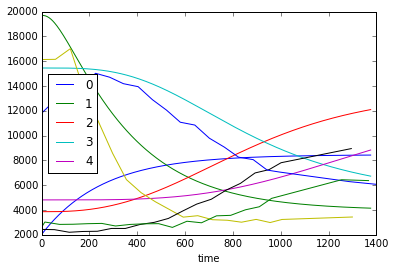

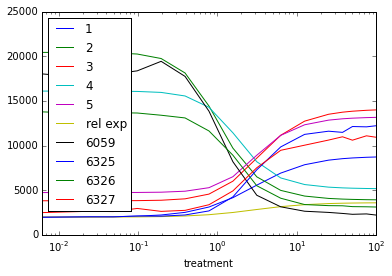

In [13]:
dt = 0.1

score, a, k, b1, b2, u, n = best_params[-1]
m = ssModel(exp_dose.index, a, k, b2, u, n) * 1600.0 + 2000.0
dose_combined = m.join(exp_dose)
k = kineticsModel(a, k, b1, u, n) * 1600.0 + 2000.0
k = k.set_index(k.index * 25.0)
k.plot()
exp_kinetics[1].plot()
exp_kinetics[2].plot()
exp_kinetics[3].plot()
exp_kinetics[4].plot()
dose_combined.plot(logx=True)

<h1> Saving Data </h1>

In [14]:
#steady state data
score, a, k, b1, b2, u, n = best_params[-1]
m = ssModel(0.006*2**np.linspace(0,20,1000), a, k, b1, u, n)
m_scaled = m.copy() * 1600.0 + 2000.0
m_scaled['rel exp'] = m['rel exp']
m_scaled.columns = ["Layer 1", "Layer 2 (6059)", "Layer 3 (6325)", "Layer 4 (6326)", "Layer 5 (6327)", "Relative Expression"]
m_scaled.index.rename("Be (nM)")
m_scaled.to_csv("/Users/Justin/Google Drive/KlavinsLab/Projects/FSM/Analysis/9-11-15_KineticsandSSFit/ss_model.csv")

#kinetics data
k = kineticsModel(a, k, b1, u, n) * 1600.0 + 2000.0
k = k.set_index(k.index * 25.0)
k.columns = ["Layer 1", "Layer 2 (6059)", "Layer 3 (6325)", "Layer 4 (6326)", "Layer 5 (6327)"]
k.index.rename("Time (min)")
k.to_csv("/Users/Justin/Google Drive/KlavinsLab/Projects/FSM/Analysis/9-11-15_KineticsandSSFit/kinetics_model.csv")

exp_dose.to_csv("/Users/Justin/Google Drive/KlavinsLab/Projects/FSM/Analysis/9-11-15_KineticsandSSFit/dose_response_experimental.csv")